# Rethinking PM2.5 Exposure: Chronic Disease Trends in the U.S. (2015 – 2019)
Chronic diseases such as cardiovascular disease, respiratory disorders, and cancer remain major health burdens in the United States. At the same time, PM2.5 air pollution continues to raise global concerns due to its proven links to respiratory and cardiovascular outcomes.
This project aims to analyze U.S. chronic disease prevalence alongside national PM2.5 trends and to compare U.S. air quality patterns with global PM2.5 levels. Together, these trends help contextualize how air pollution may relate to population health in the United States.

In [1]:
import os
from config import DATA_DIR, RESULTS_DIR, aqs_epa_url, chronic_url, global_url
from load import retrieve_file_pm25, retrieve_file_chronic, retrieve_file_pm25_global
from analyze import calculate_correlation, mixed_effects_model, plot_us_trends, plot_global_comparison, plot_disease_heatmap, plot_all_chronic_trends, plot_correlation_bar_chart, plot_correlation_scatters, plot_grouped_bar_charts, plot_mixed_effects_forest
from process import process_pm25_us, process_chronic, process_pm25_global, aggregate_us_pm25, aggregate_us_chronic, aggregate_global_pm25, merge_us_data

#  U.S. EPA AQS API data

In [2]:
# Create a data directory
os.makedirs(DATA_DIR, exist_ok=True)

# --- U.S. EPA AQS API data ---
pm25_us_data = retrieve_file_pm25(aqs_epa_url)
df_pm25_us_processed = process_pm25_us(pm25_us_data)

# Aggregate PM2.5 and get the clean DataFrame
if df_pm25_us_processed is not None:
    df_pm25_us_agg = aggregate_us_pm25(df_pm25_us_processed)
    print(f"\nU.S. PM2.5 Aggregated Data Head:\n{df_pm25_us_agg.head()}\n")

Loading data from https://aqs.epa.gov/data/api/annualData/byState...
U.S. PM2.5 concentration data loaded successfully

Processing U.S. PM2.5 data...
    Total data points extracted: Year 2015 = 2910
    Total data points extracted: Year 2016 = 2588
    Total data points extracted: Year 2017 = 2826
    Total data points extracted: Year 2018 = 3197
    Total data points extracted: Year 2019 = 2902
    Total data points extracted: Year 2020 = 3515
    Total data points extracted: Year 2021 = 3772
    Total data points extracted: Year 2022 = 3560
U.S. PM2.5 concentration data processed successfully


Aggregating 40 State-Year raw mean lists...
Aggregated U.S. PM2.5 size: (40, 3)
U.S. PM2.5 data aggregation successful.


U.S. PM2.5 Aggregated Data Head:
   year       state   avg_pm25
0  2015  California   9.672352
1  2015    Colorado   6.501713
2  2015    Illinois  10.029168
3  2015    New York   7.886730
4  2015       Texas   9.572449



# U.S. Chronic disease data from web

In [3]:
# --- U.S. chronic disease data from web---
chronic_data = retrieve_file_chronic(chronic_url)
df_chronic_processed = process_chronic(chronic_data)

# Aggregate chronic disease and get the clean DataFrame
if df_chronic_processed is not None:
    df_chronic_agg = aggregate_us_chronic(df_chronic_processed)
    print(f"\nU.S. Chronic Disease Aggregated Data Head:\n{df_chronic_agg.head()}")

Loading data from https://data.cdc.gov/api/views/hksd-2xuw/rows.json?accessType=DOWNLOAD...
U.S. Chronic disease data loaded successfully

Processing U.S. chronic disease data...
Filter ==> Pre-Explode Cleaned Rows: 654
Filter ==> Final Rows After Explode and Year Filter: 684
Chronic disease data processed successfully.

Aggregating chronic disease data...
Aggregated chronic size: (290, 6)
Chronic disease data aggregation successful.


U.S. Chronic Disease Aggregated Data Head:
        state  year                                disease unit  \
0  California  2019                                Alcohol    %   
1  California  2019                              Arthritis    %   
2  California  2019                                 Asthma    %   
3  California  2019                 Cardiovascular Disease    %   
4  California  2019  Chronic Obstructive Pulmonary Disease    %   

   avg_prevalence  n_obs  
0       17.300000      1  
1       31.685714      7  
2        8.300000      1  
3     

# Global PM2.5 data from Google drive

In [4]:
pm25_global_data = retrieve_file_pm25_global(global_url, extract_dir=DATA_DIR)
df_pm_global_processed = process_pm25_global(pm25_global_data)

# Aggregate global PM2.5 and get the clean DataFrame
if df_pm_global_processed is not None:
    df_global_agg = aggregate_global_pm25(df_pm_global_processed)
    print(f"\nGlobal PM 2.5 Aggregated Data Head:\n{df_global_agg.head()}")

Loading data from https://drive.google.com/file/d/1Biiamr8qiEv3IZi0o8E7O1ylMBfcuBJh/view?usp=share_link...
Global PM2.5 concentration data saved to ../data/global_pm25.csv
Loading ../data/global_pm25.csv into DataFrame...
Global PM2.5 concentration data loaded successfully

Processing Global PM2.5 data...
    Data length: Global PM2.5 (5 years) = 4725
Global PM2.5 data processed successfully

Aggregating Global PM2.5 data to Worldwide Average...
Aggregated chronic size: (5, 2)
Global PM2.5 aggregation successful.


Global PM 2.5 Aggregated Data Head:
   year  Global_PM25
0  2015    23.845333
1  2016    23.411725
2  2017    23.131481
3  2018    23.087026
4  2019    22.175884


# Merge the two U.S. datasets for analysis

In [5]:
if df_pm25_us_agg is not None and df_chronic_agg is not None:
    df_merged_us = merge_us_data(df_pm25_us_agg, df_chronic_agg)
    print(f"\nMerged Avg. U.S. Data Head:\n{df_merged_us.head()}")
print("\n--- Data aggregation and merging complete. Proceed to analysis. ---")

Merging PM2.5 and chronic data...
Merged dataset size: (310, 7)

Merged Avg. U.S. Data Head:
        state  year  disease unit  avg_prevalence  n_obs   avg_pm25
0  California  2015      NaN  NaN             NaN    NaN   9.672352
1  California  2016      NaN  NaN             NaN    NaN   9.168501
2  California  2017      NaN  NaN             NaN    NaN   9.681820
3  California  2018      NaN  NaN             NaN    NaN  10.471050
4  California  2019  Alcohol    %            17.3    1.0   7.850570

--- Data aggregation and merging complete. Proceed to analysis. ---


# ANALYSIS AND VISUALIZATION

# Correlation analysis, correlation bar chart and scatter plots

--- Performing Correlation Analysis ---
Results for Alcohol Rate vs. PM2.5: rho = -0.3033, P-Value = 0.1935
Results for Arthritis Rate vs. PM2.5: rho = 0.2107, P-Value = 0.4510
Results for Asthma Rate vs. PM2.5: rho = -0.5064, P-Value = 0.0227
Results for Cardiovascular Disease Rate vs. PM2.5: rho = 0.1885, P-Value = 0.6021
Results for Chronic Obstructive Pulmonary Disease Rate vs. PM2.5: rho = 0.1753, P-Value = 0.4599
Results for Cognitive Health and Caregiving Rate vs. PM2.5: rho = -0.1783, P-Value = 0.4790
Results for Diabetes Rate vs. PM2.5: rho = 0.4332, P-Value = 0.0564
Results for Disability Rate vs. PM2.5: rho = 0.2333, P-Value = 0.3223
Results for Health Status Rate vs. PM2.5: rho = 0.1309, P-Value = 0.5823
Results for Immunization Rate vs. PM2.5: rho = -0.4797, P-Value = 0.0323
Results for Mental Health Rate vs. PM2.5: rho = -0.1595, P-Value = 0.5019
Results for Nutrition, Physical Activity, and Weight Status Rate vs. PM2.5: rho = 0.1113, P-Value = 0.6405
Results for Social D

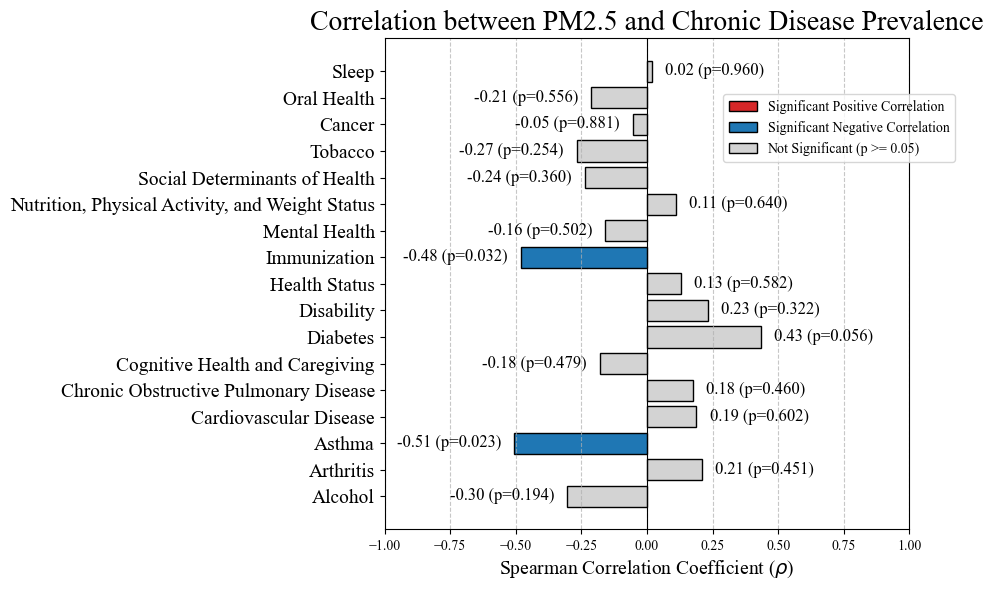


--- Generating Individual Scatter Plot ---


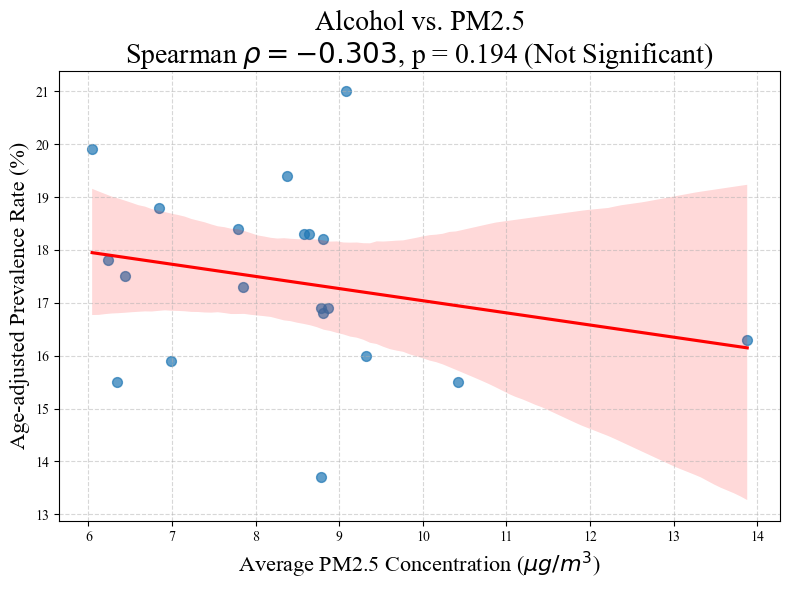

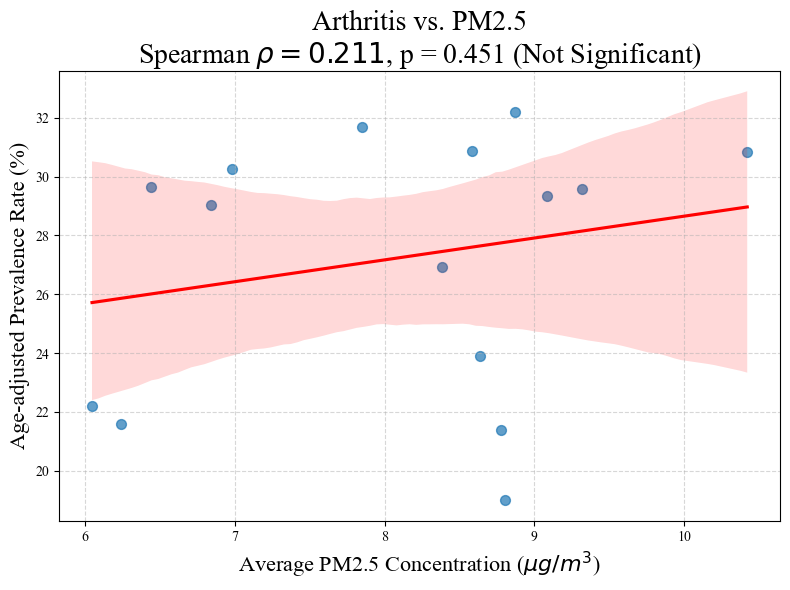

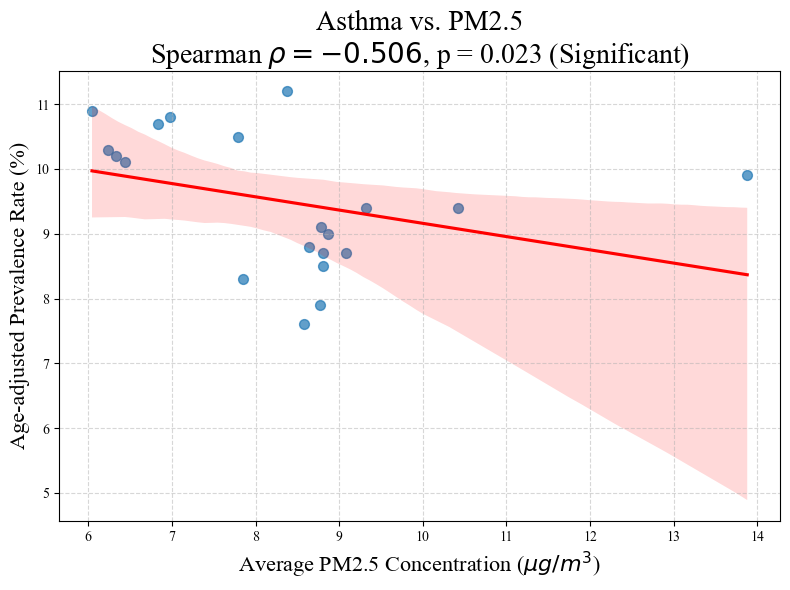

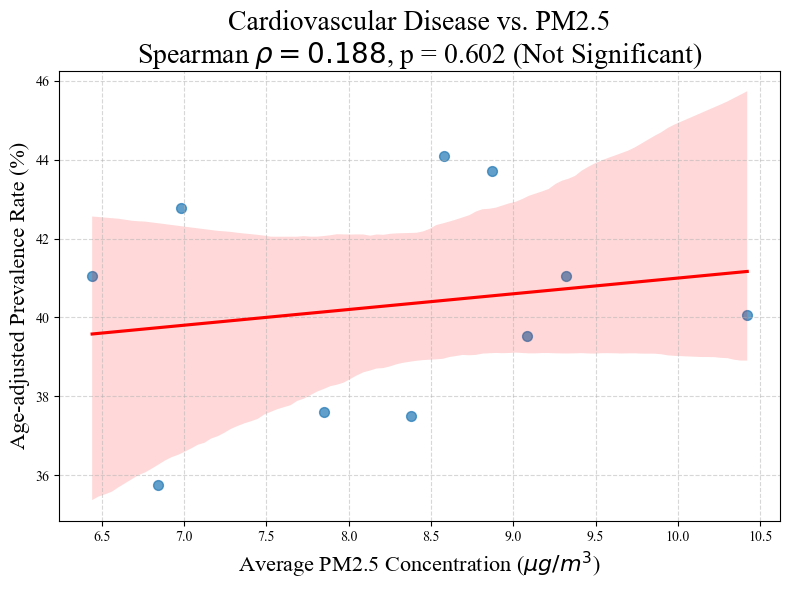

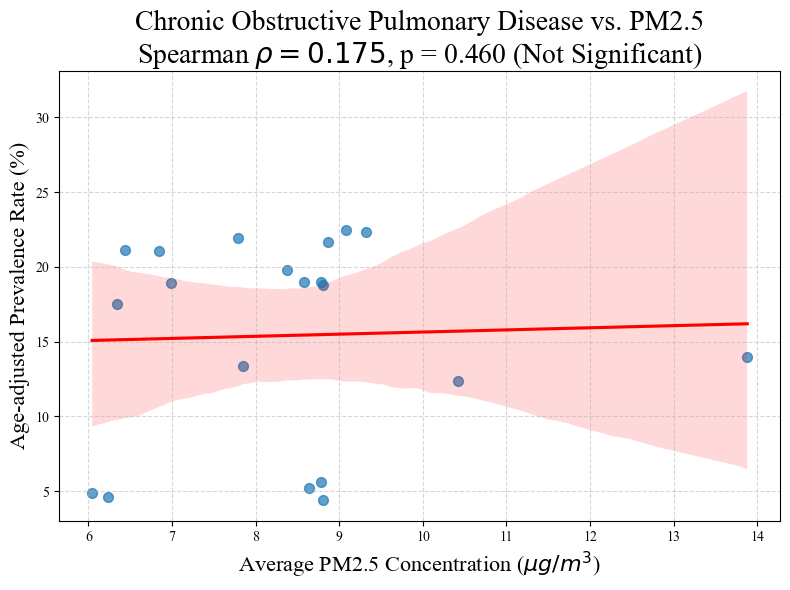

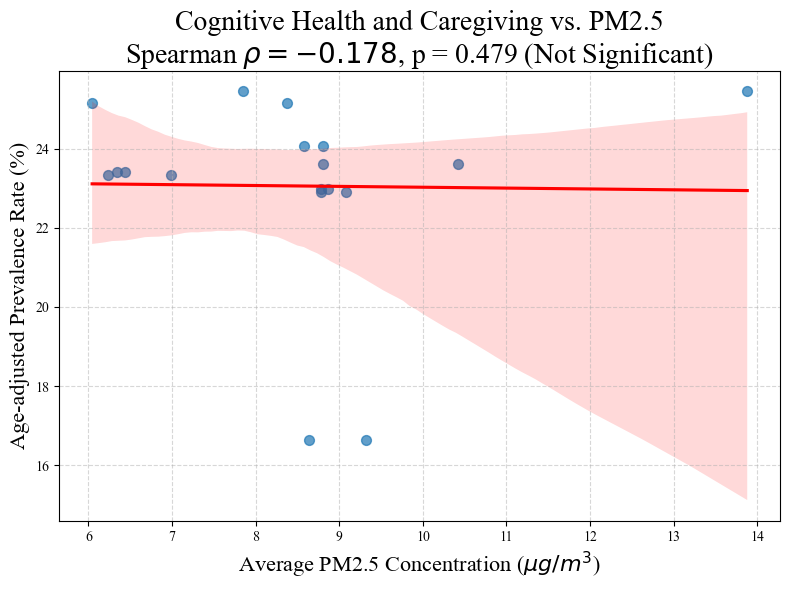

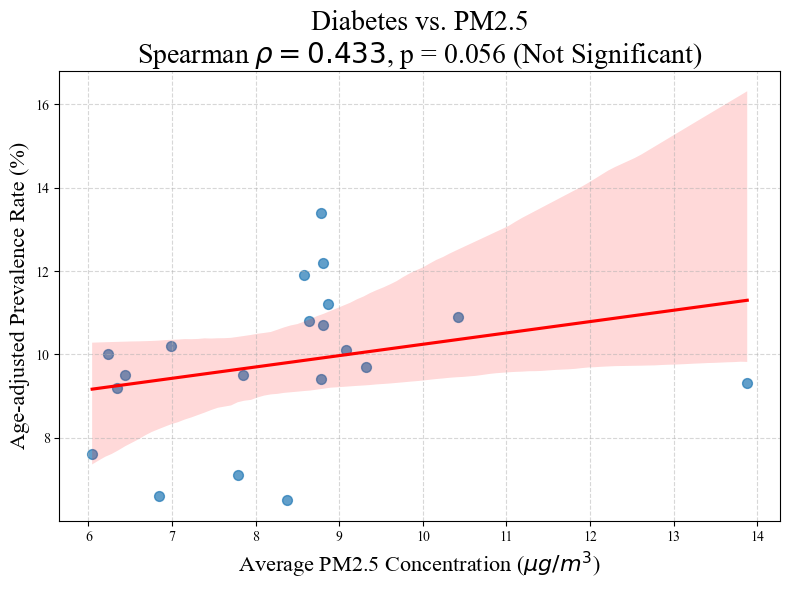

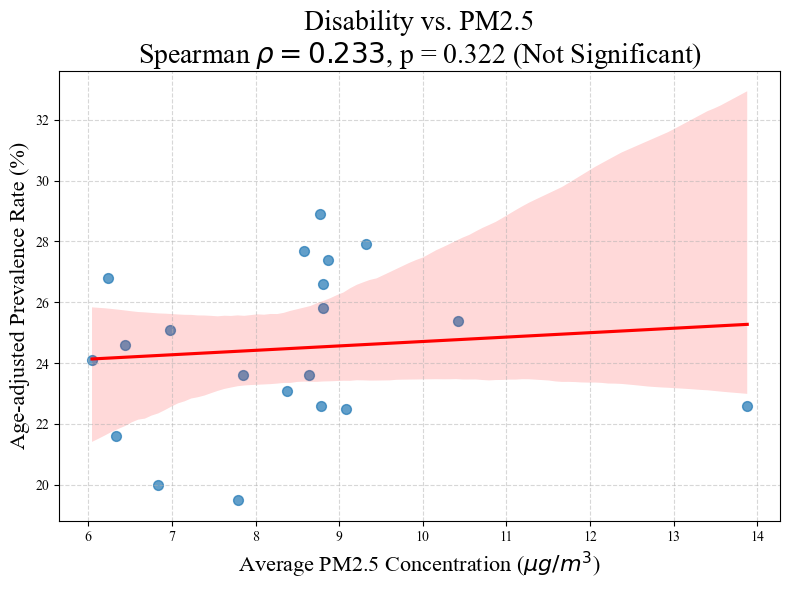

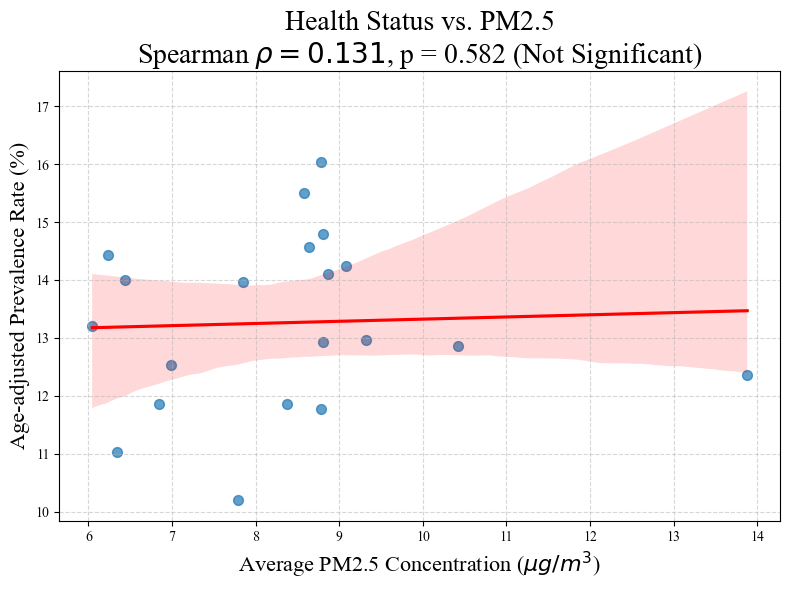

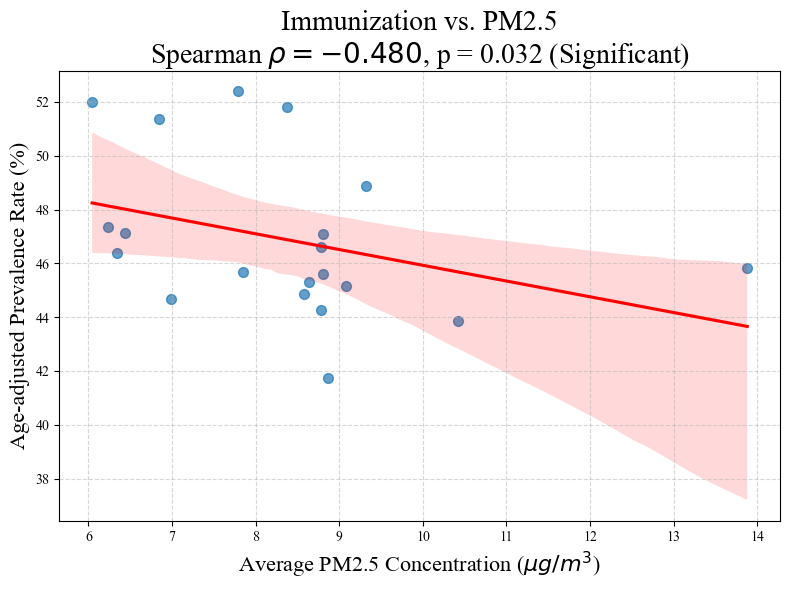

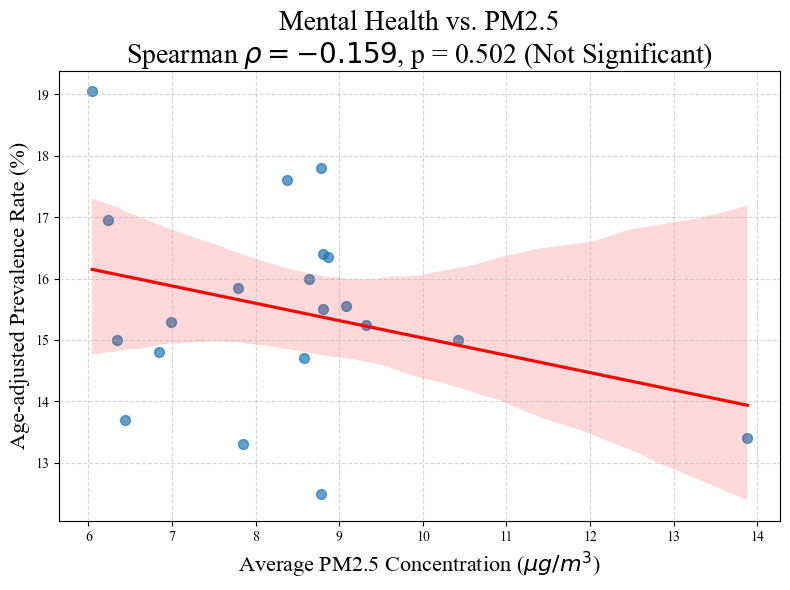

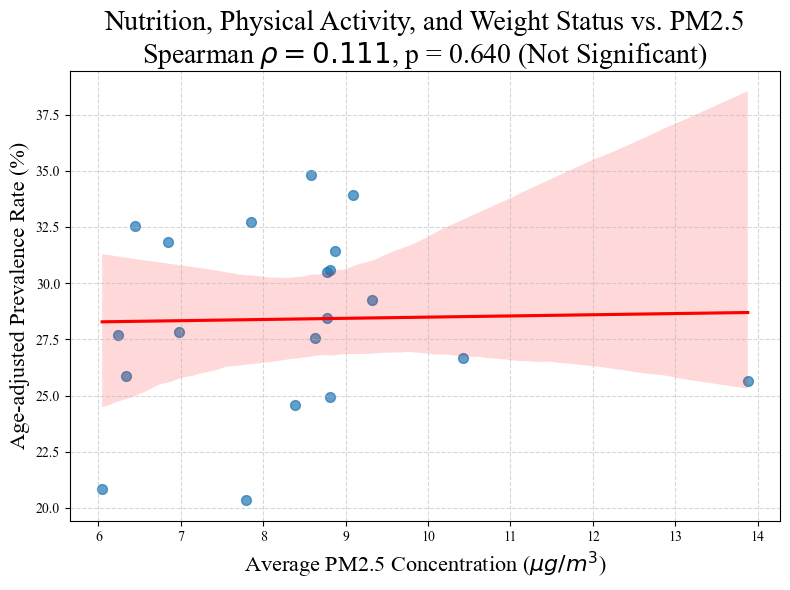

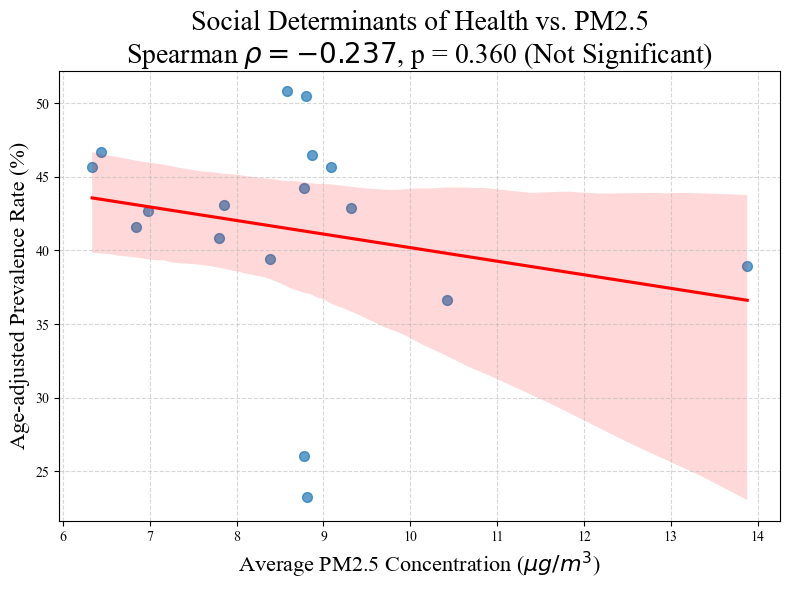

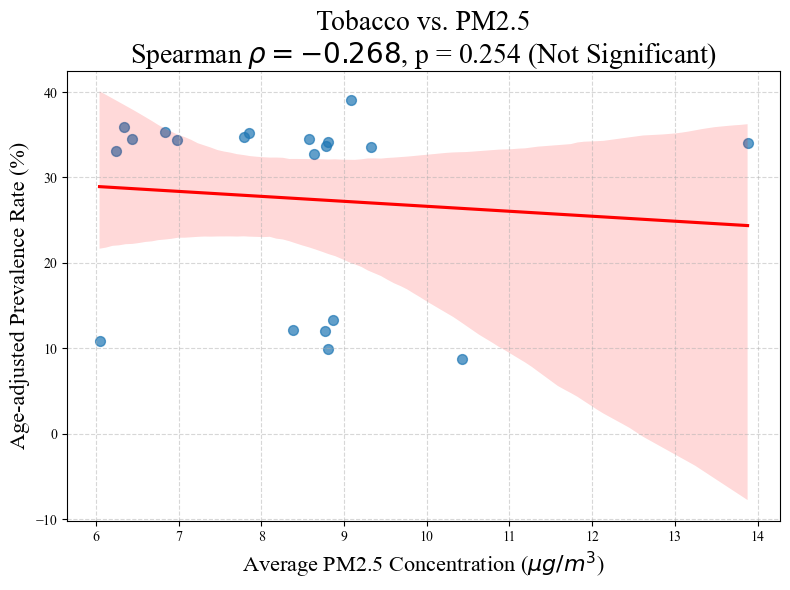

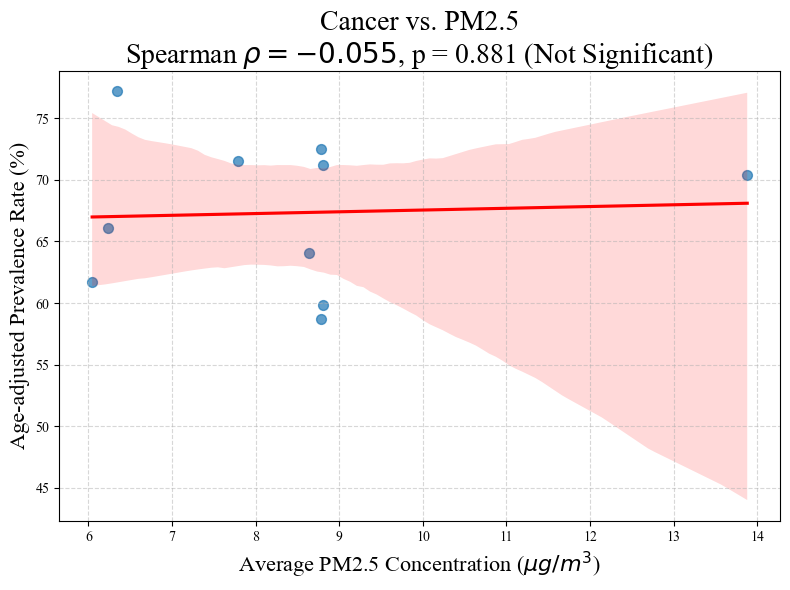

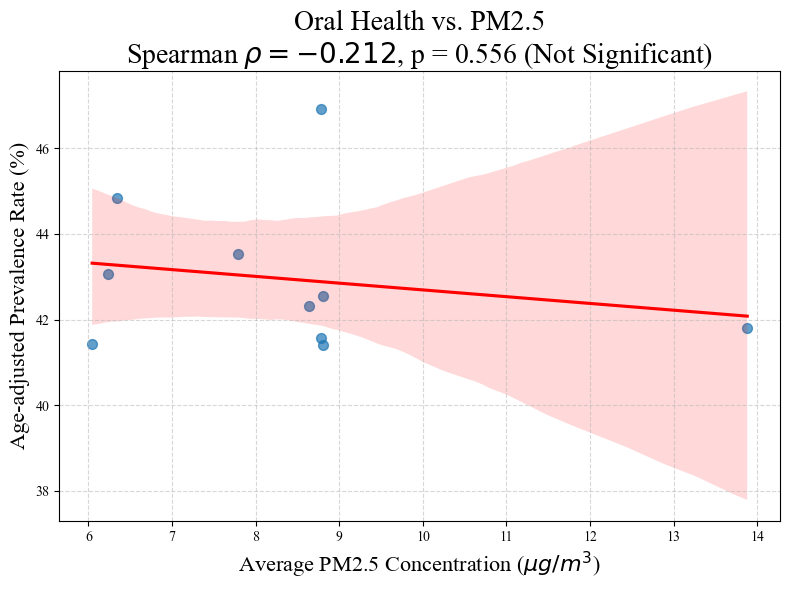

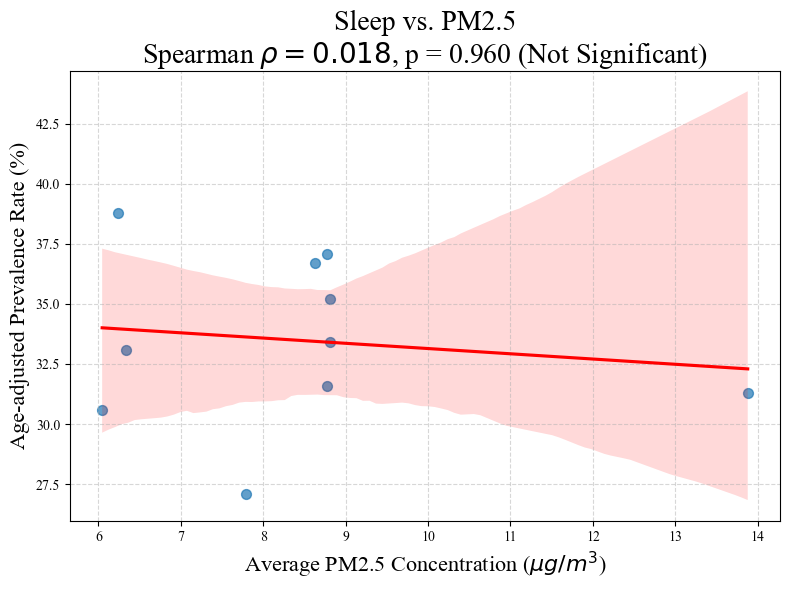

In [9]:
if df_merged_us is not None:
    correlation_results = calculate_correlation(df_merged_us)

    print("\n--- Summary Correlation Results ---")
    for disease, res in correlation_results.items():
        if res['status'] == 'Success':
            print(f"  {disease}: rho={res['rho']:.4f}, p={res['p_value']:.4f}")
        else:
            print(f"  {disease}: {res['status']}")
    plot_correlation_bar_chart(correlation_results, RESULTS_DIR, notebook_plot=True)
    plot_correlation_scatters(df_merged_us, correlation_results, RESULTS_DIR, notebook_plot=True)

# Mixed-Effects Models analysis


--- Performing Mixed-Effects Models ---

================ GLOBAL MIXED MODEL ================
                                    Mixed Linear Model Regression Results
Model:                              MixedLM                   Dependent Variable:                   prevalence
No. Observations:                   290                       Method:                               ML        
No. Groups:                         5                         Scale:                                17.9149   
Min. group size:                    56                        Log-Likelihood:                       -832.1009 
Max. group size:                    59                        Converged:                            Yes       
Mean group size:                    58.0                                                                      
--------------------------------------------------------------------------------------------------------------
                                                      

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/regression/mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-p

            Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  prevalence
No. Observations:    20       Method:              ML        
No. Groups:          5        Scale:               0.6696    
Min. group size:     4        Log-Likelihood:      -27.3132  
Max. group size:     4        Converged:           Yes       
Mean group size:     4.0                                     
-------------------------------------------------------------
            Coef.   Std.Err.   z    P>|z|   [0.025    0.975] 
-------------------------------------------------------------
Intercept -1969.995  331.020 -5.951 0.000 -2618.783 -1321.208
pm25         -0.208    0.140 -1.483 0.138    -0.483     0.067
year          0.984    0.164  6.004 0.000     0.662     1.305
Group Var     0.376    0.497                                 


--- Nutrition, Physical Activity, and Weight Status ---
          Mixed Linear Model Regression Results
Model:              MixedLM Dependent 

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)


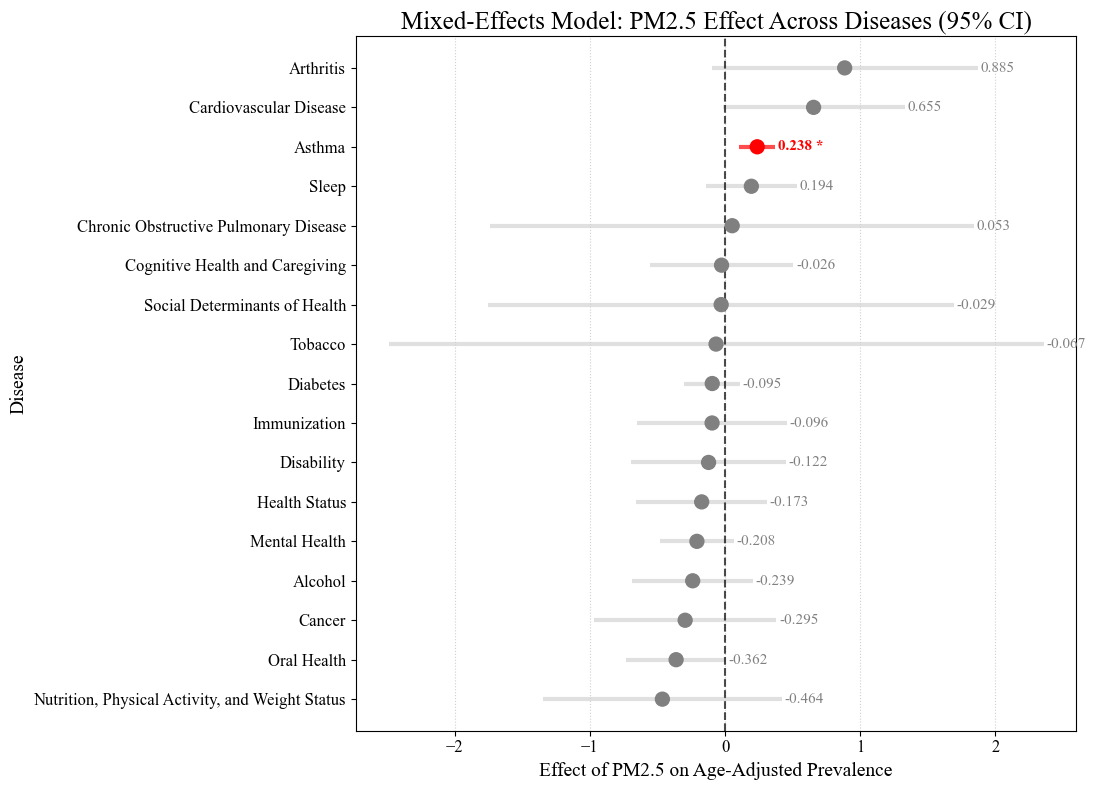

In [10]:
if df_merged_us is not None:
    mixed_effects_results = mixed_effects_model(df_merged_us)
    plot_mixed_effects_forest(mixed_effects_results, RESULTS_DIR, notebook_plot=True)

# Generate U.S. PM2.5 and chronic disease prevalence trend plots


--- Generating U.S. Trend Plots ---


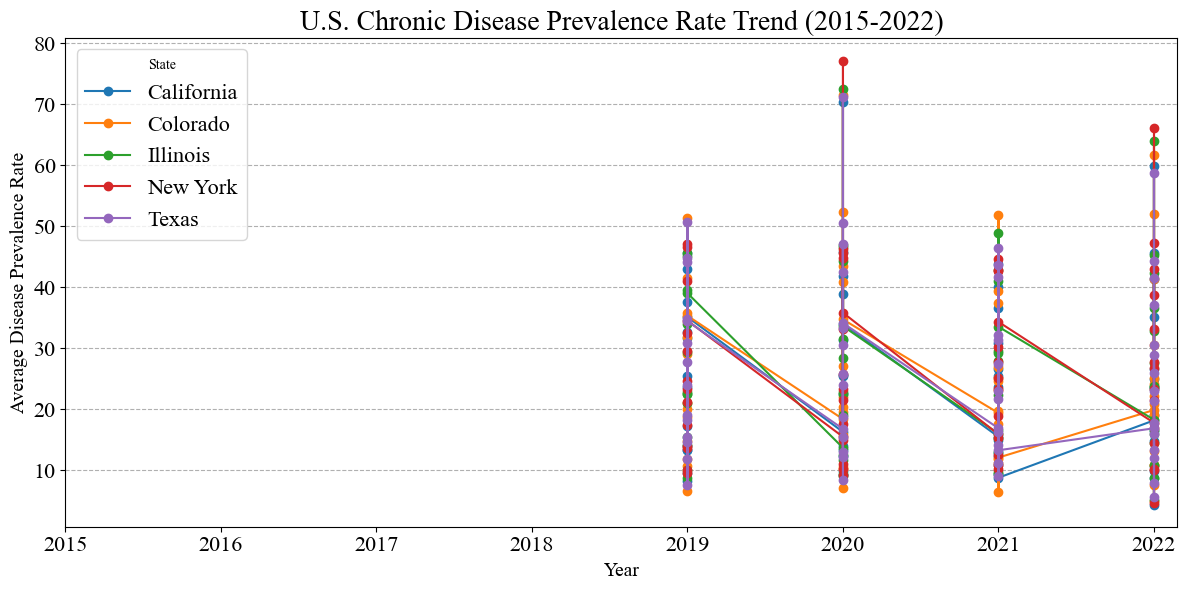

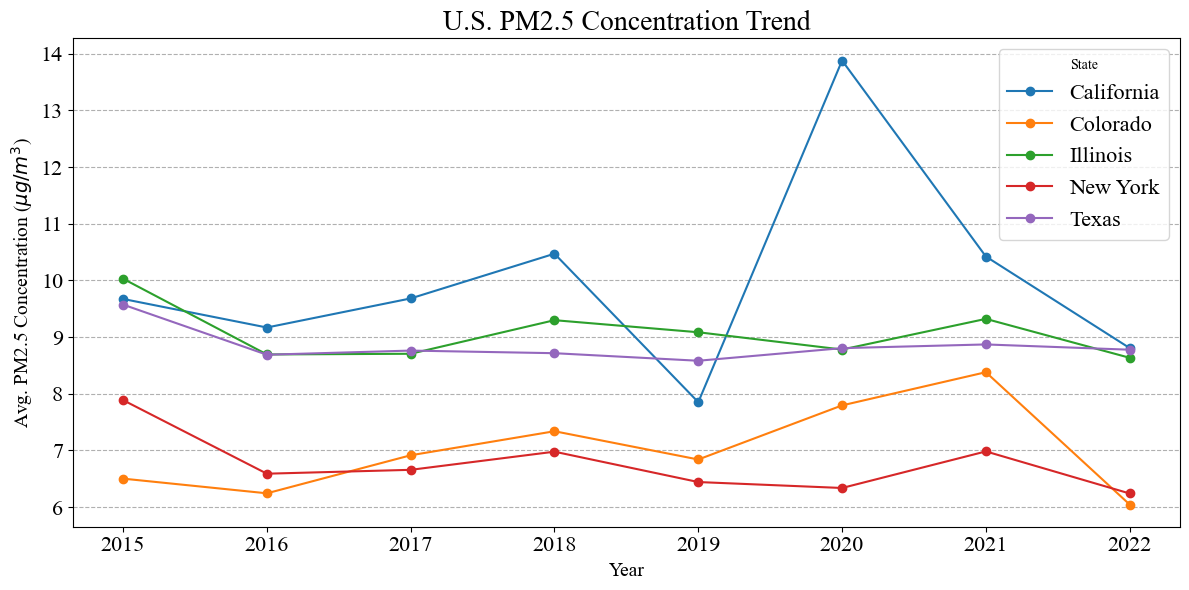


--- Generating Chronic Disease Heatmap ---


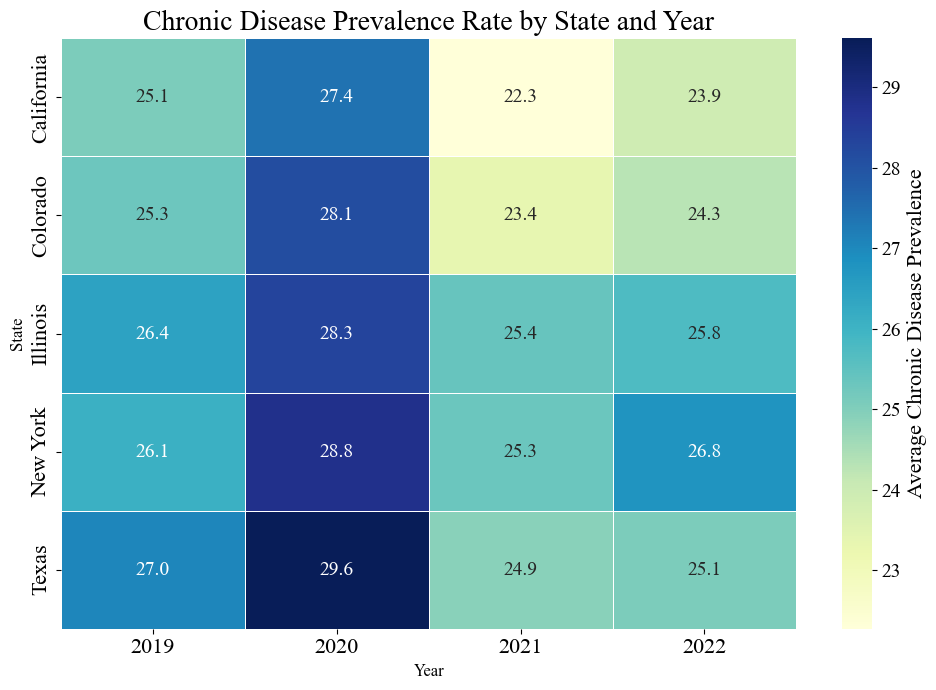

In [11]:
if df_merged_us is not None:
    plot_us_trends(df_merged_us, RESULTS_DIR, notebook_plot=True)
    plot_disease_heatmap(df_merged_us, RESULTS_DIR, notebook_plot=True)

# Generate 17 chronic disease prevalence trend plots and grouped bar charts


--- Generating All Chronic Diseases Trend Plots ---
Skipping plot for nan (nan): No data found.


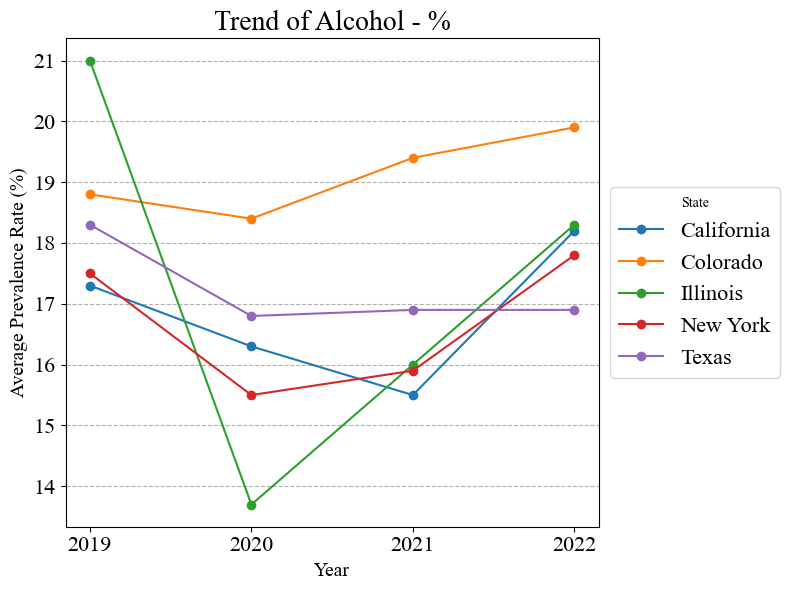

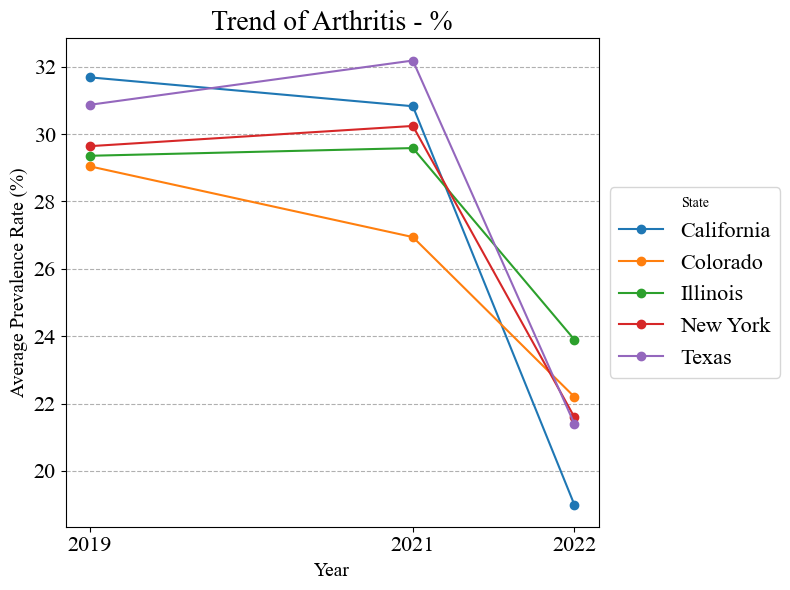

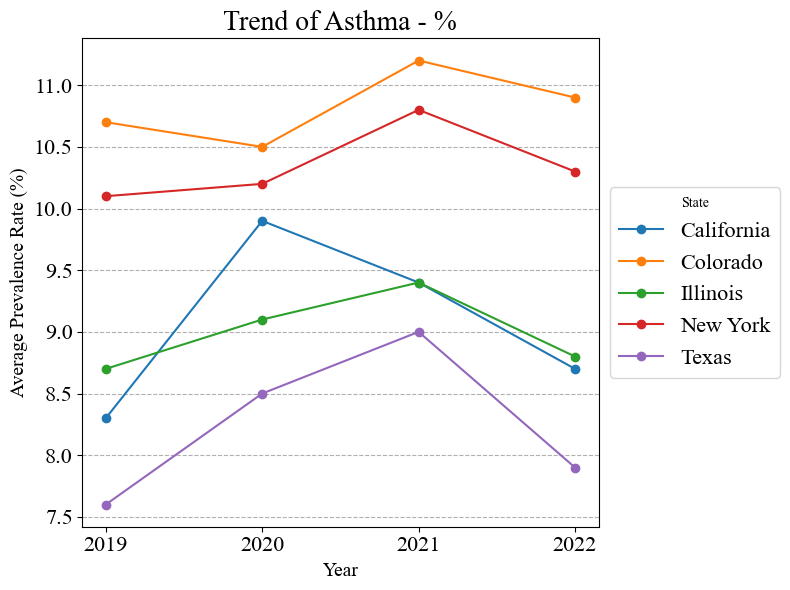

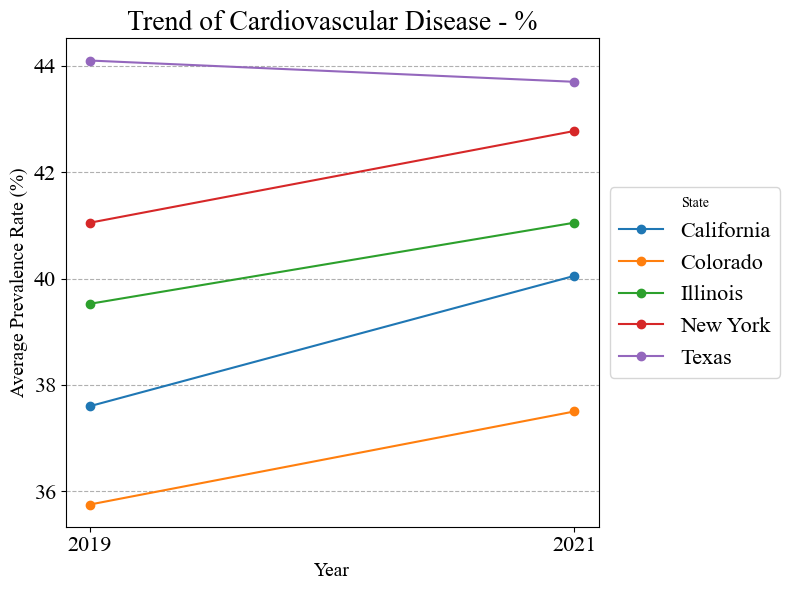

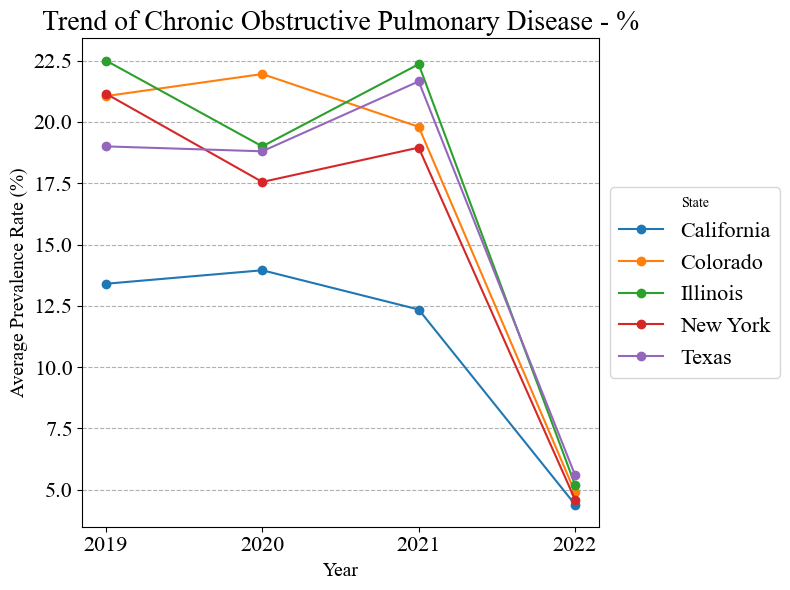

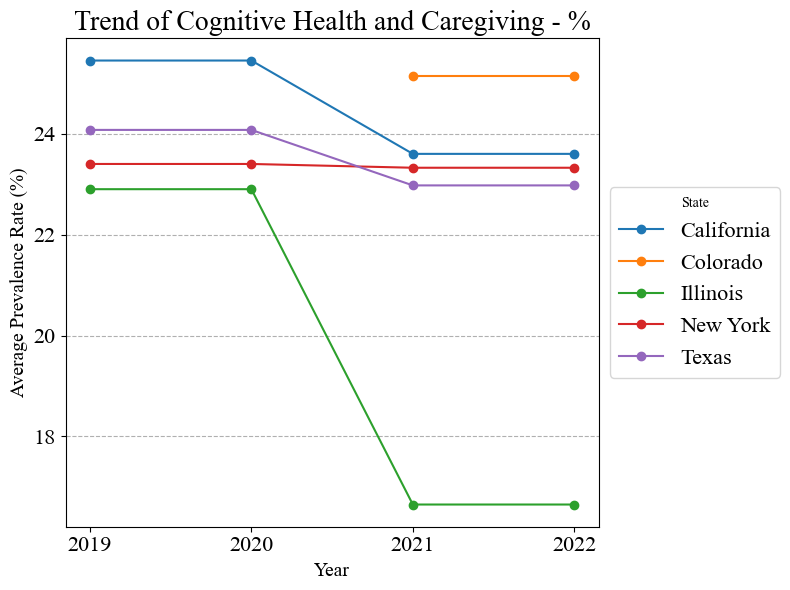

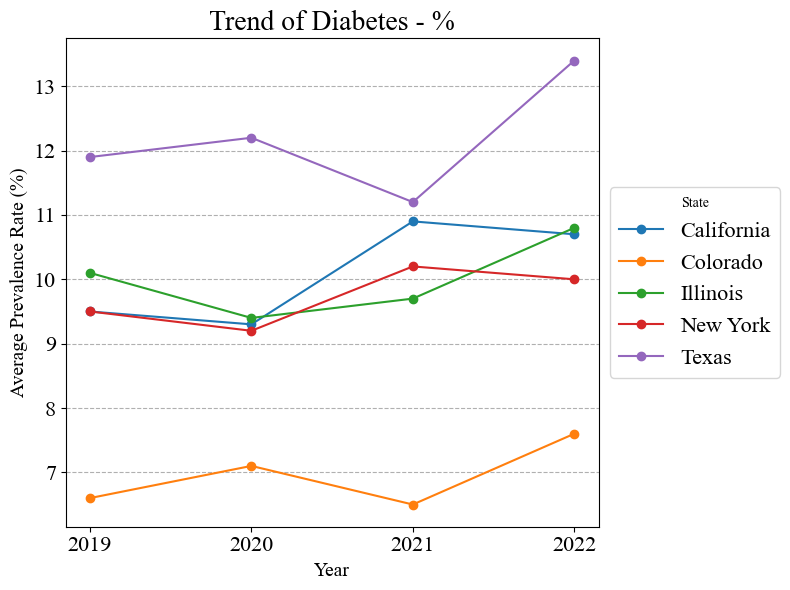

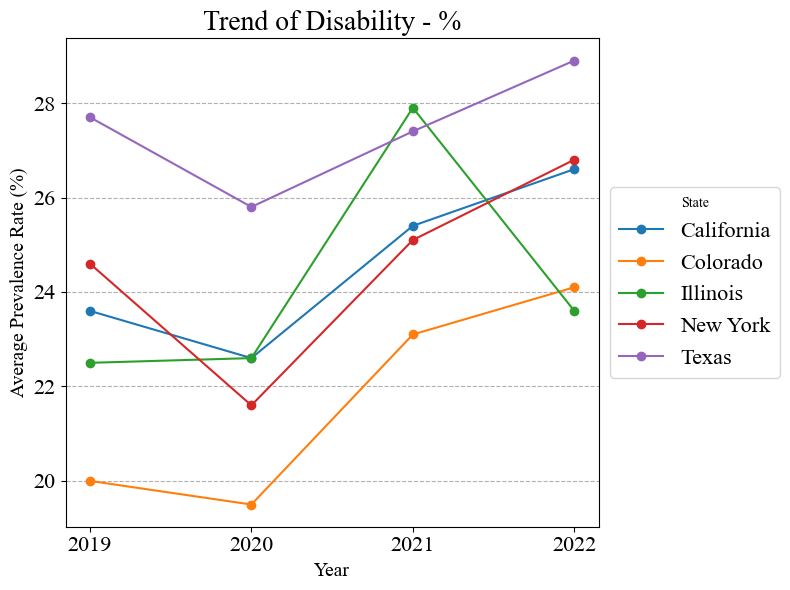

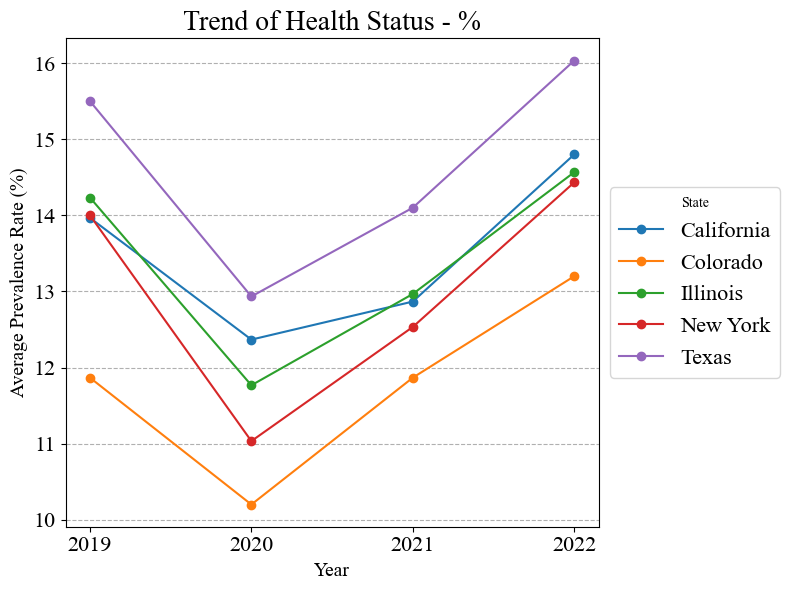

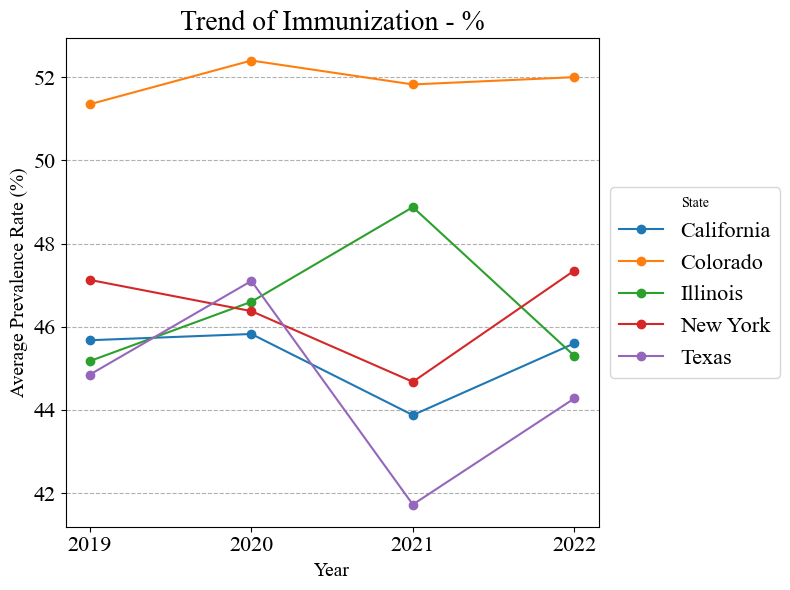

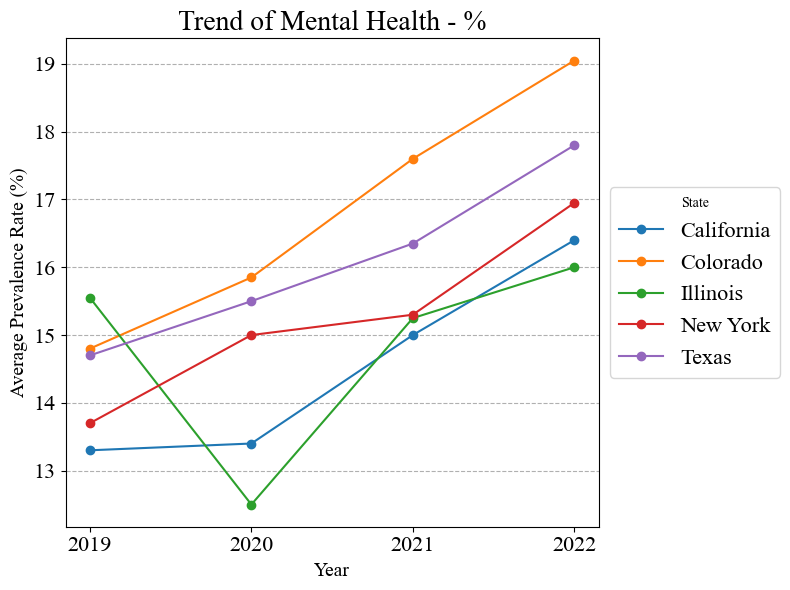

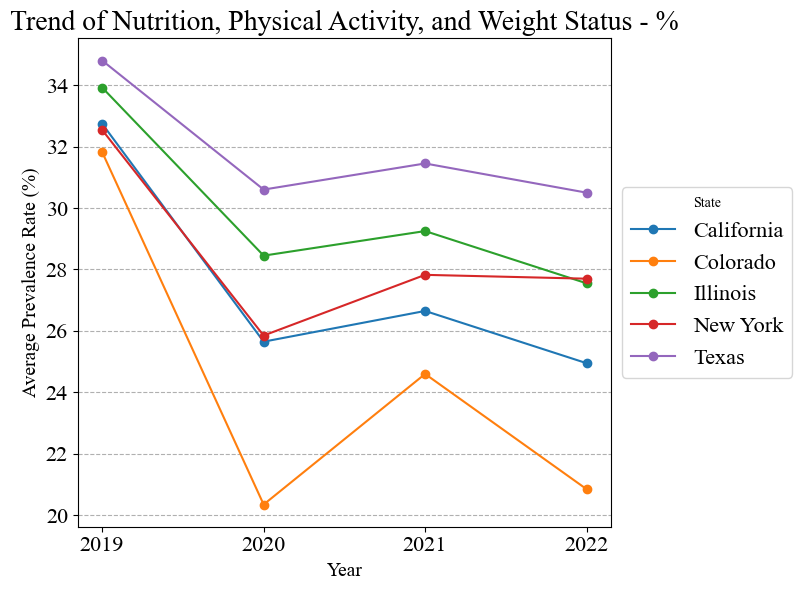

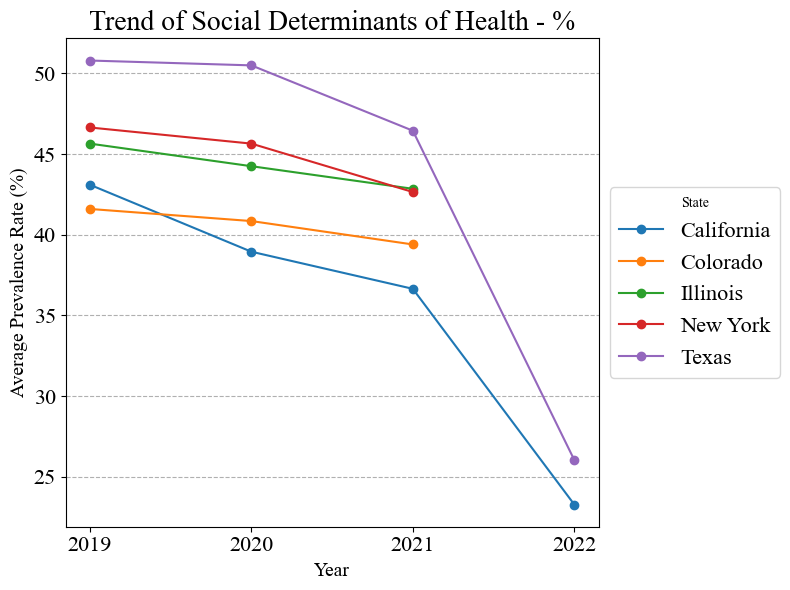

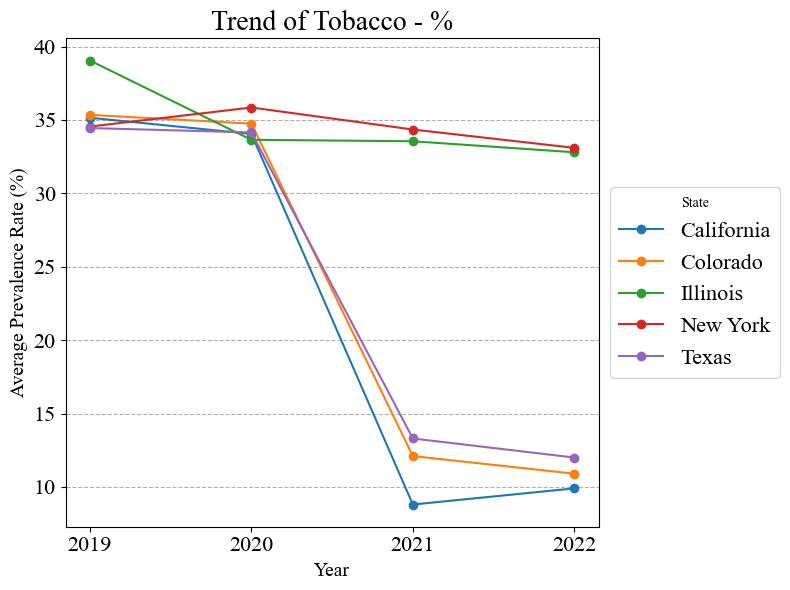

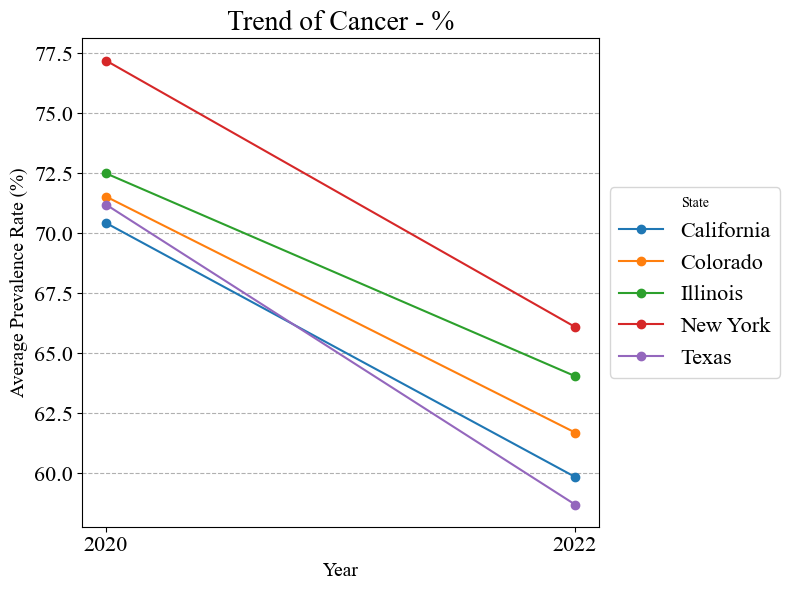

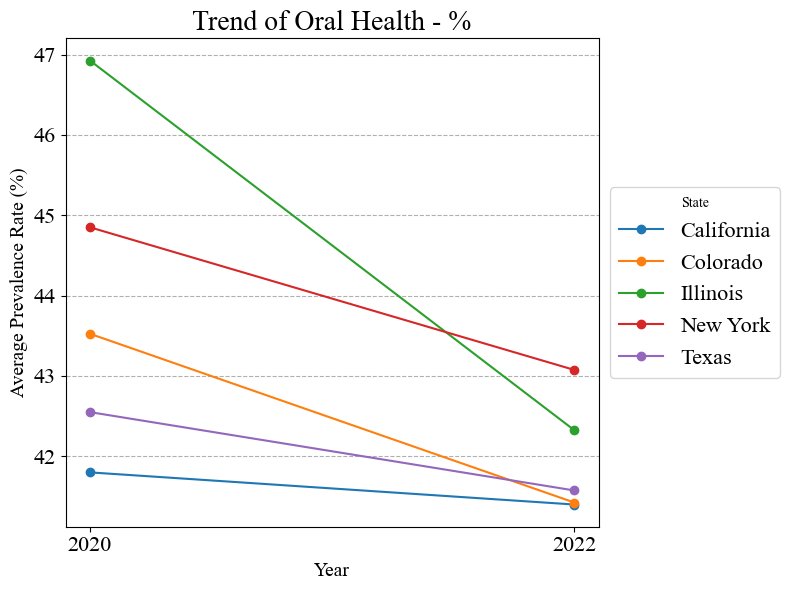

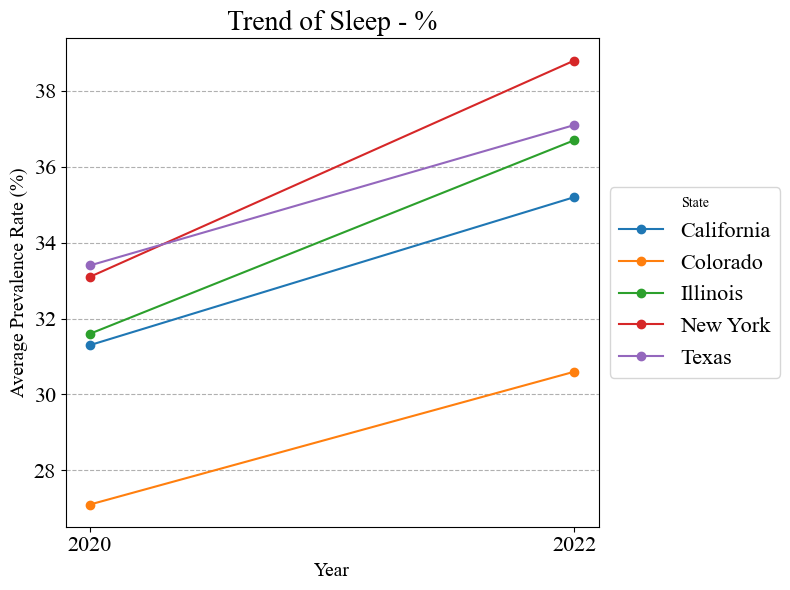


--- Generating Grouped Bar Charts ---
Skipping grouped bar chart for nan: No valid data.


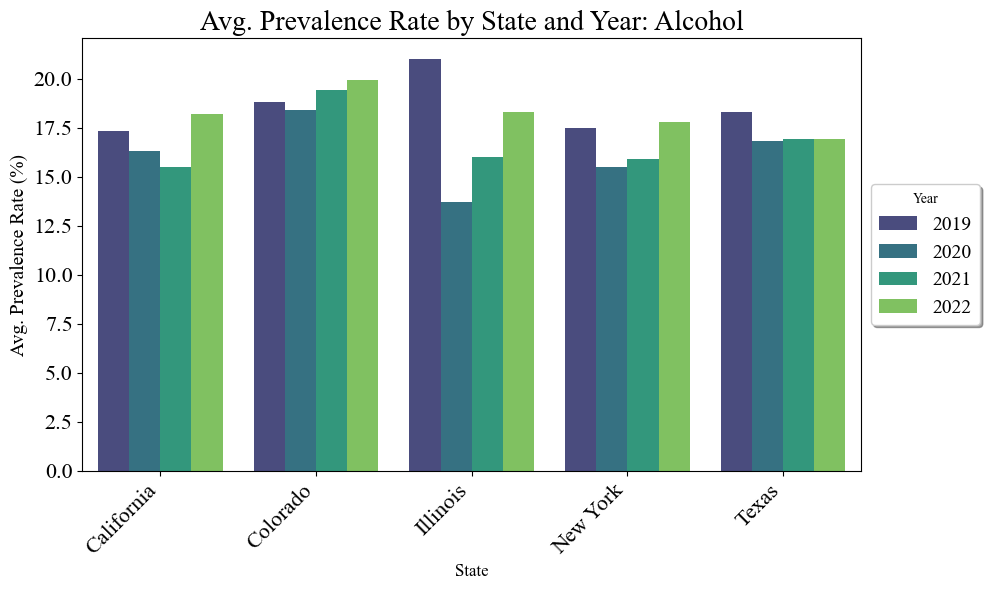

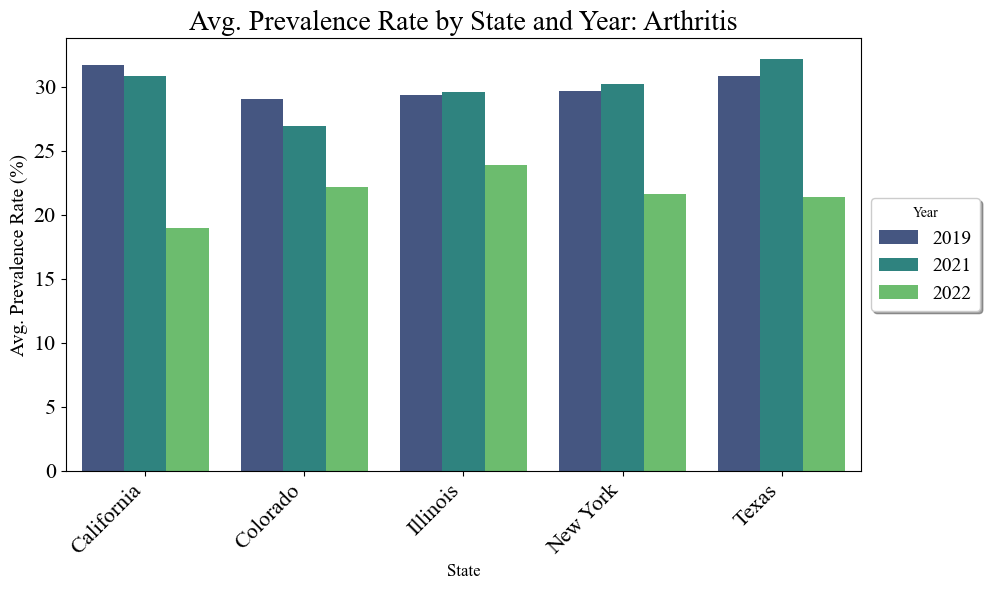

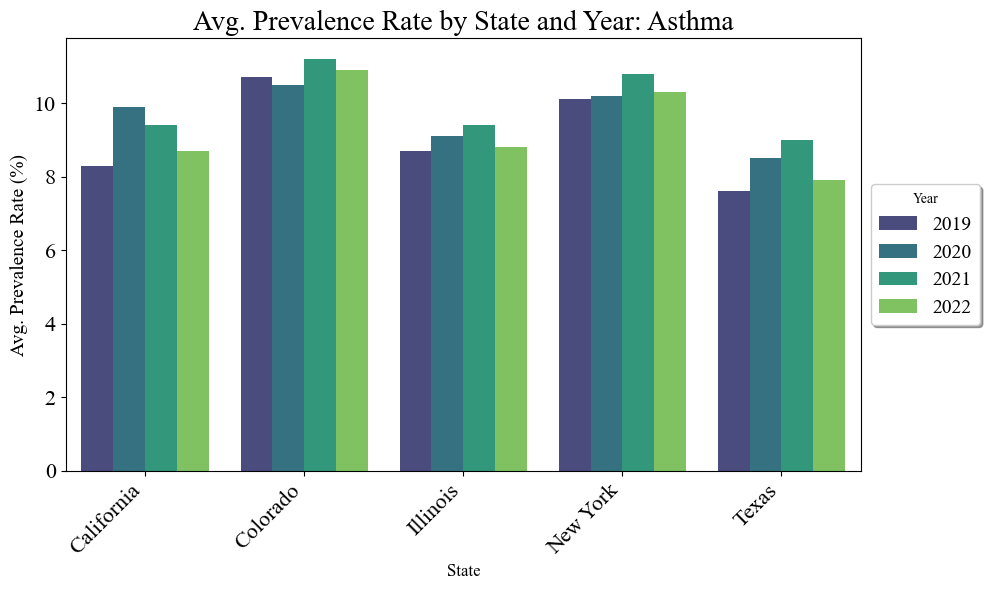

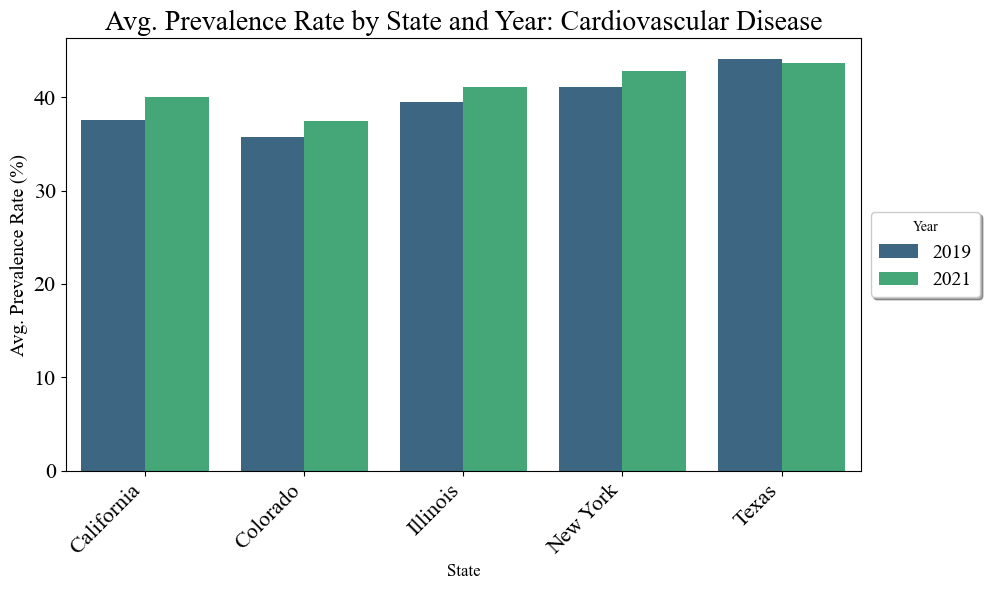

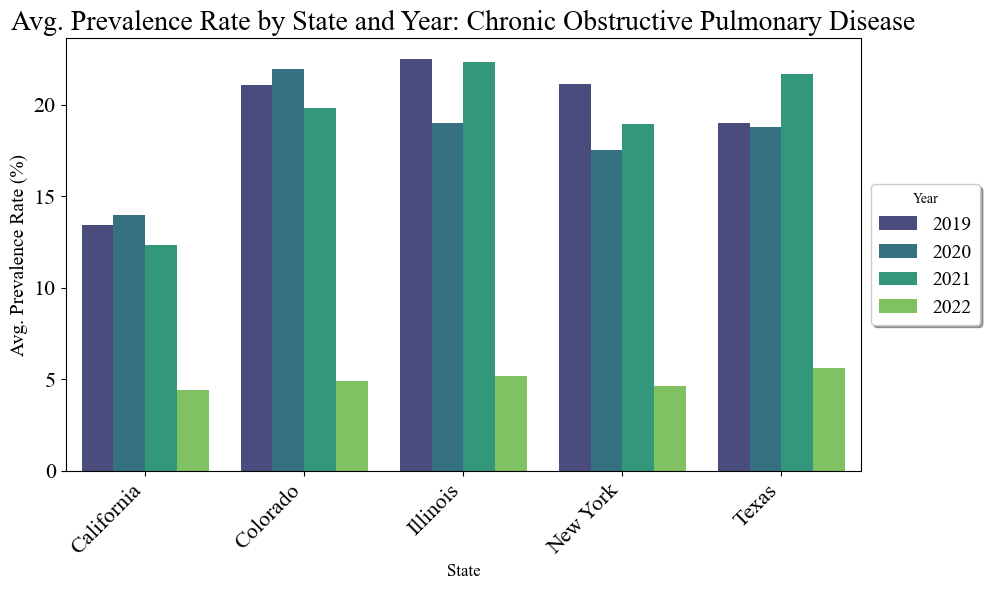

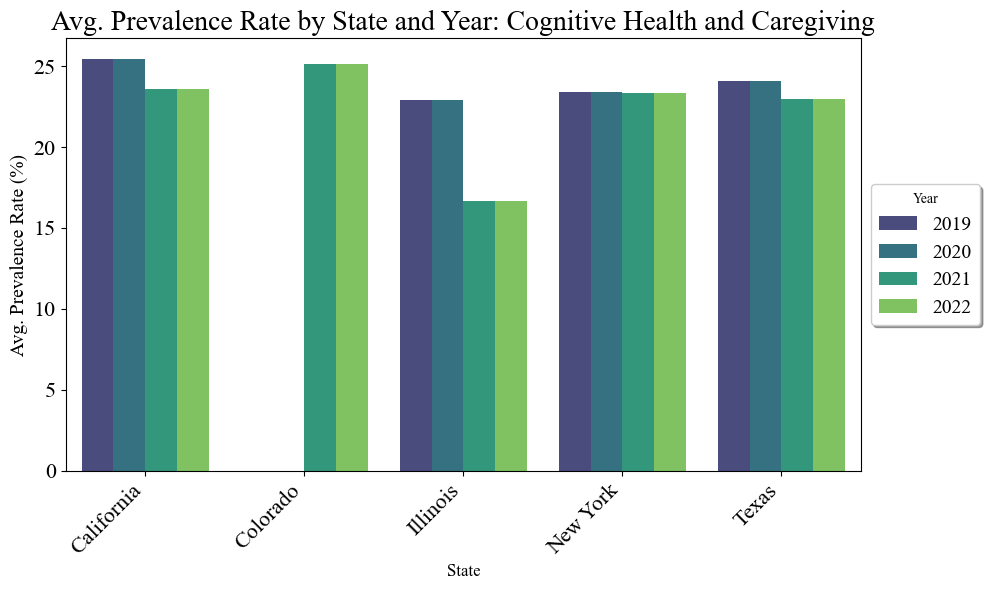

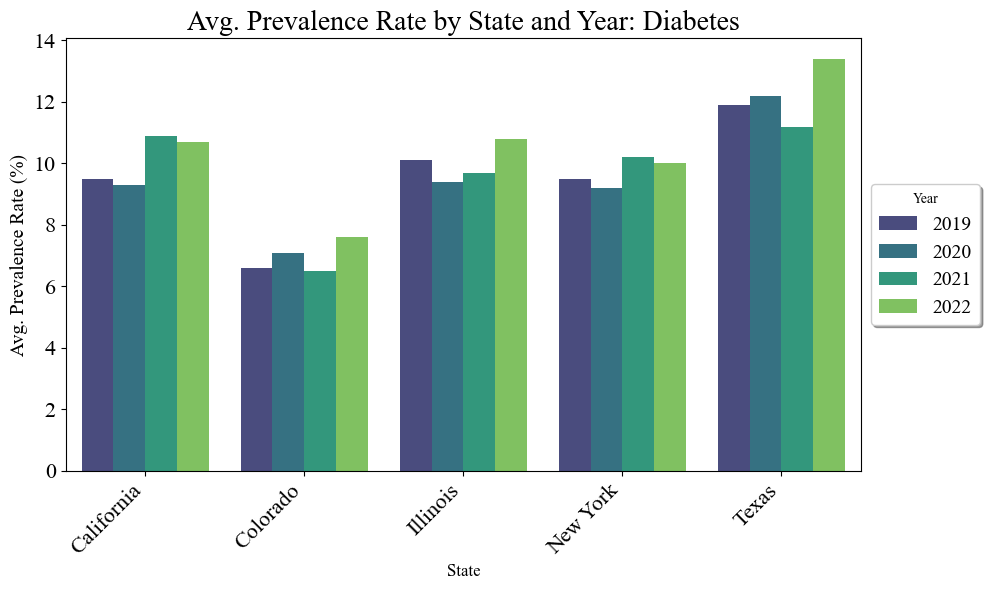

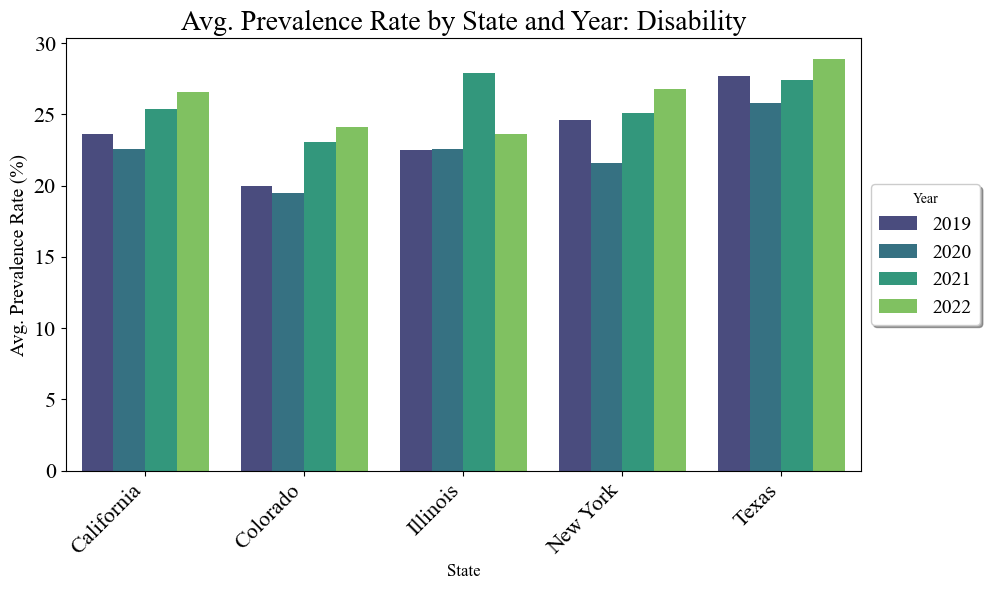

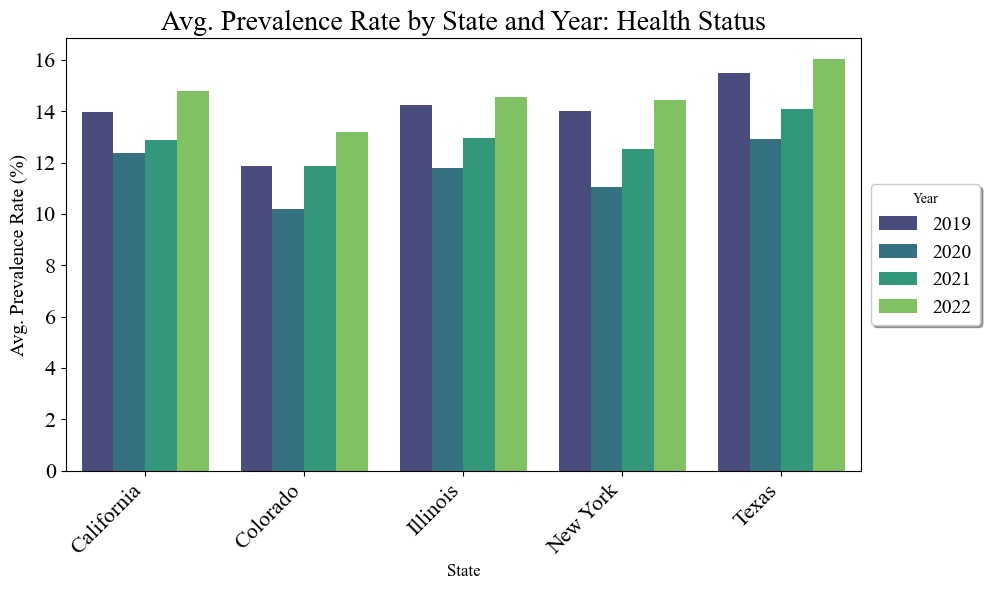

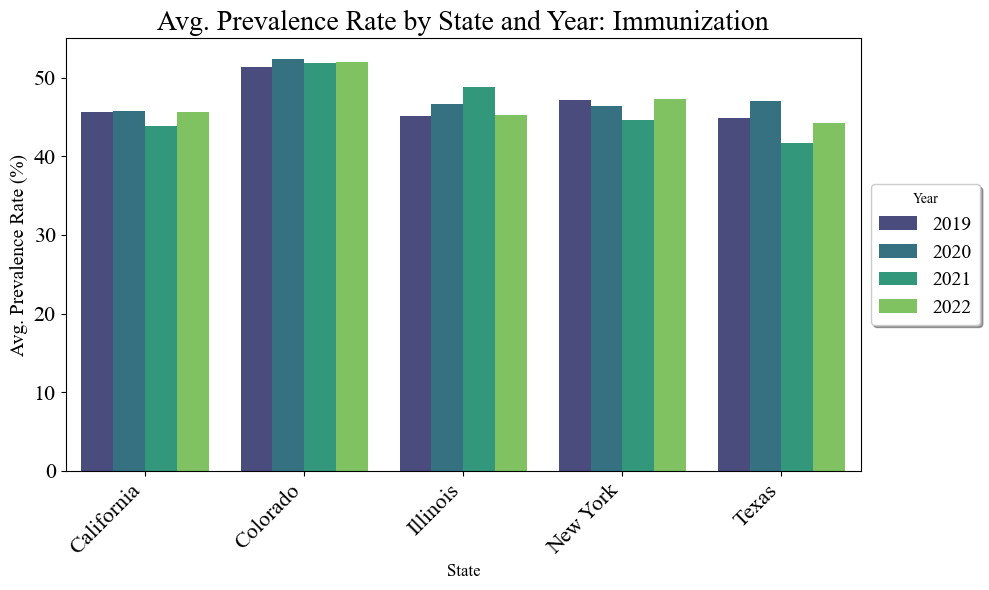

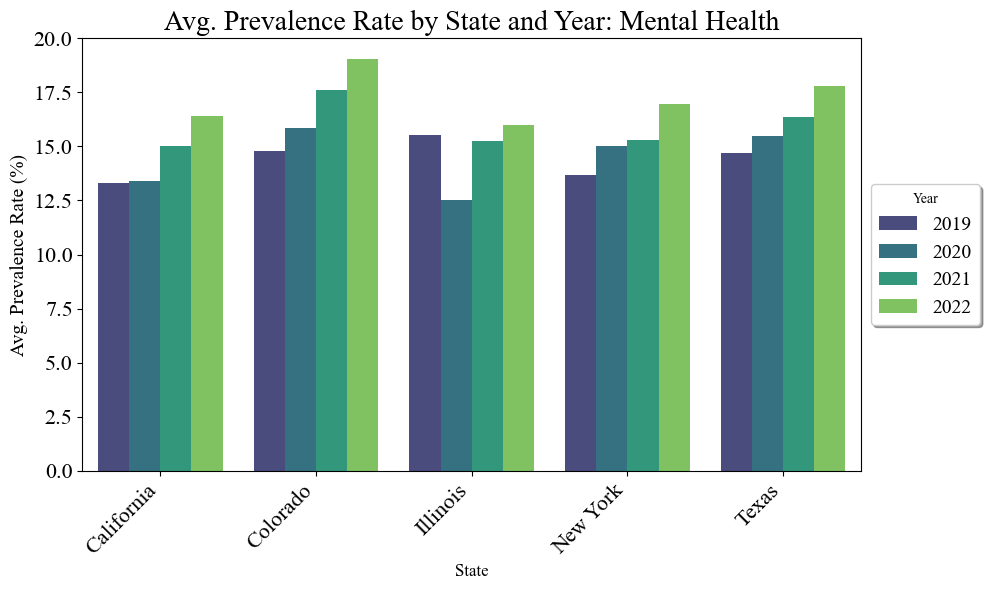

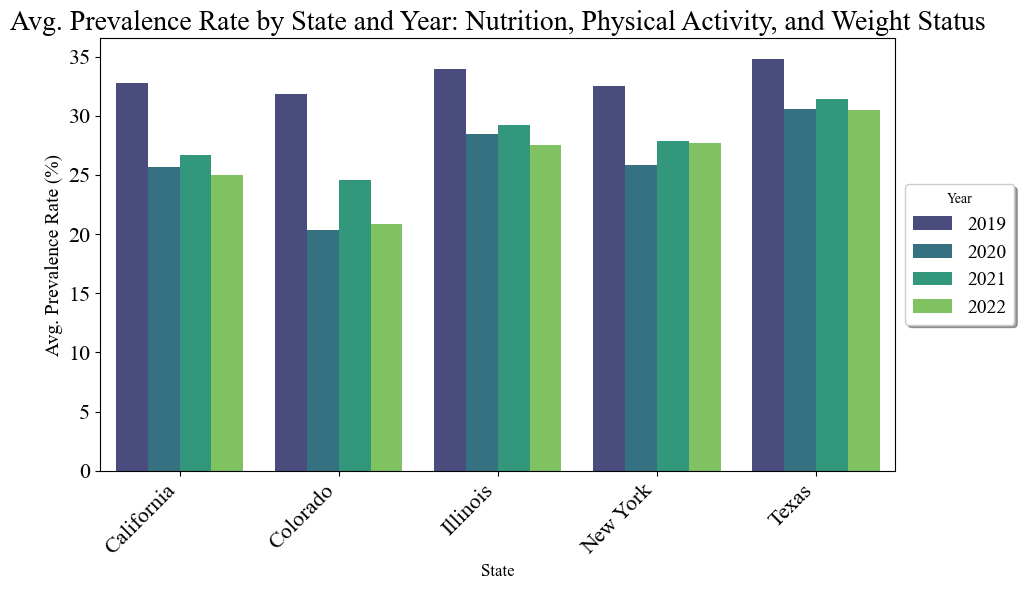

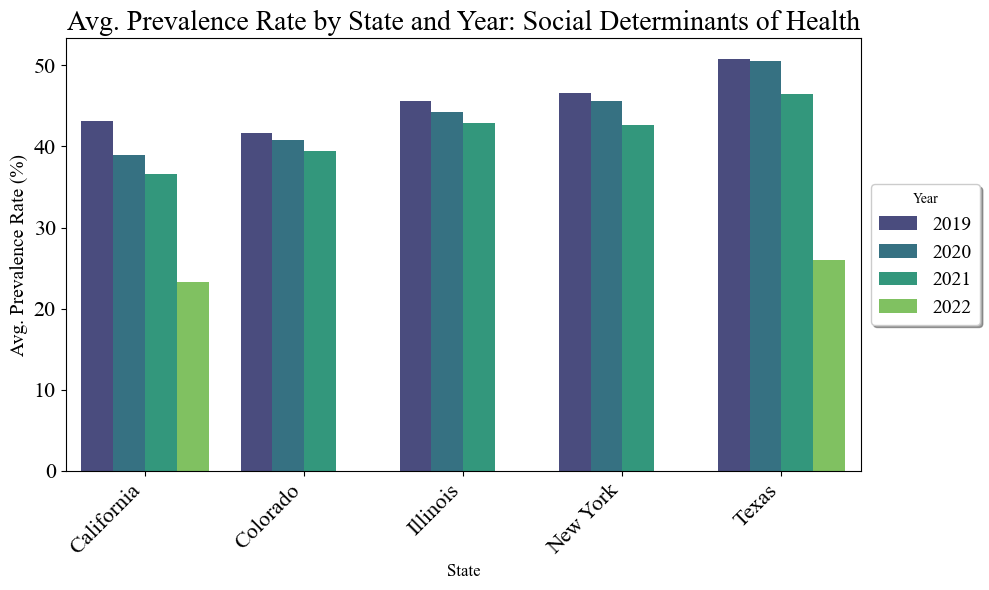

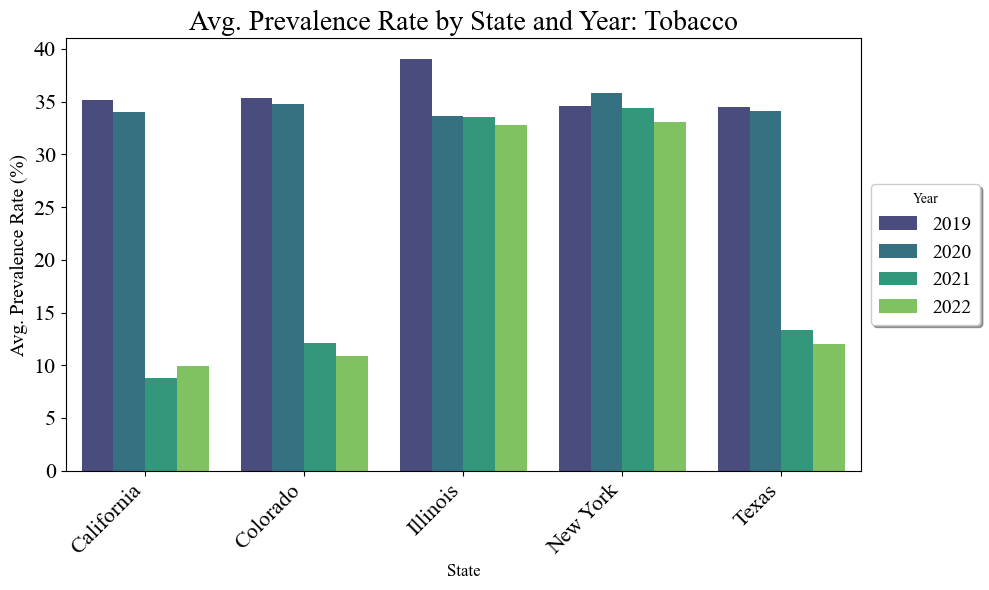

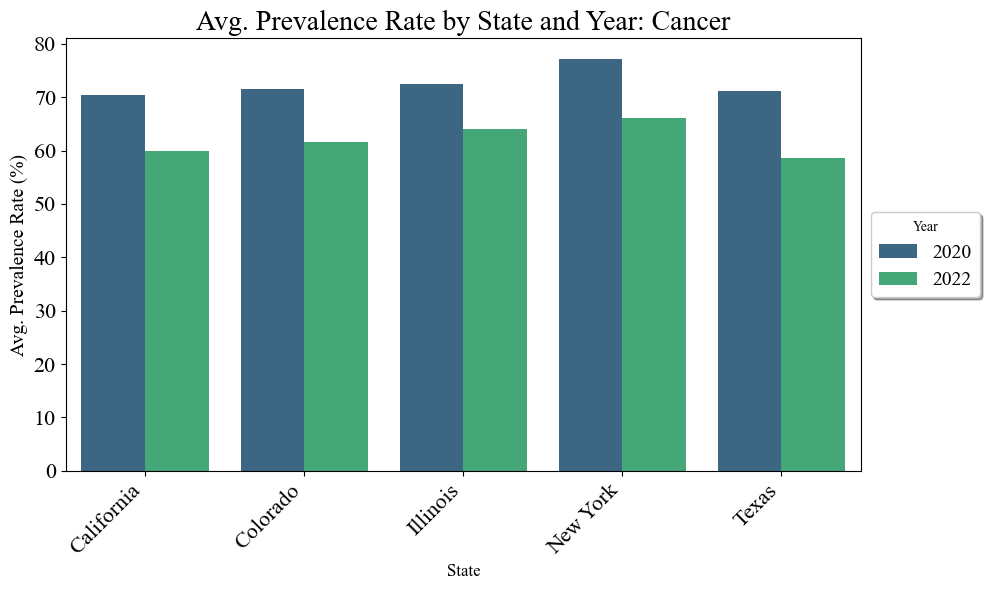

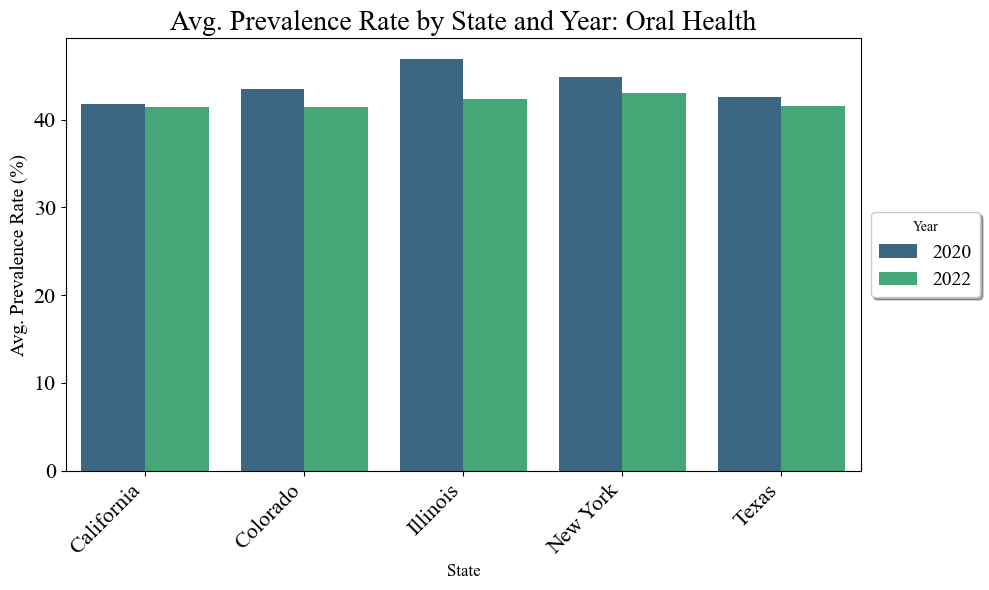

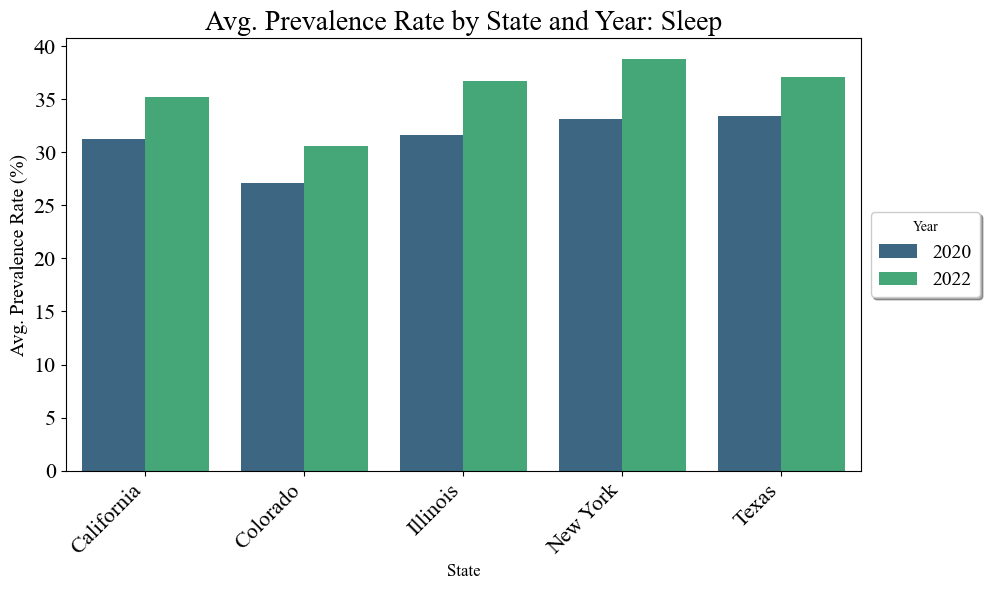

In [12]:
if df_merged_us is not None:
    plot_all_chronic_trends(df_merged_us, RESULTS_DIR, notebook_plot=True)
    plot_grouped_bar_charts(df_merged_us, RESULTS_DIR, notebook_plot=True)

# Generate global PM2.5 comparison plots


--- Generating Global Comparison Plot ---


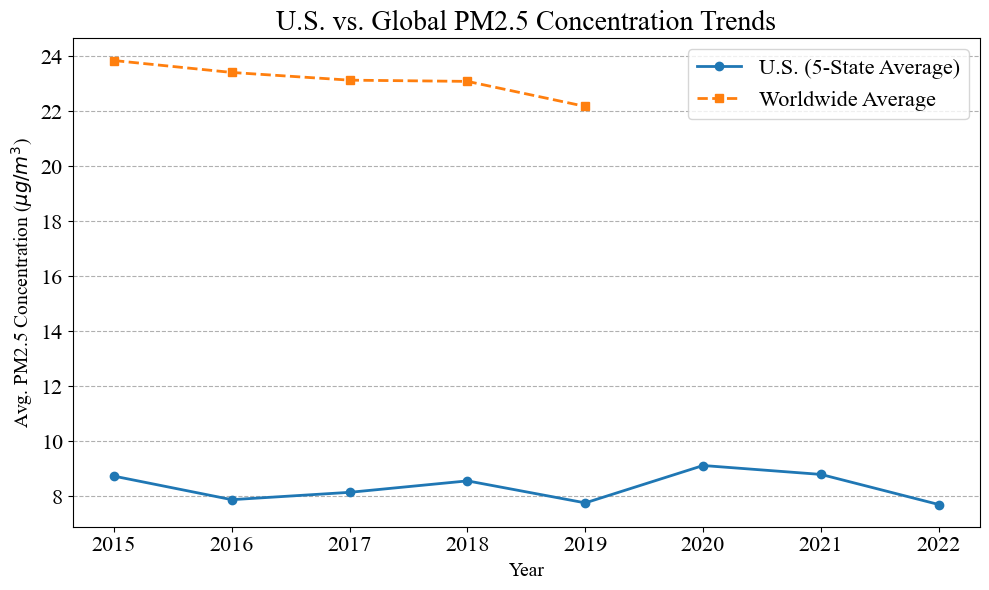

In [13]:
if df_pm25_us_agg is not None and df_global_agg is not None:
    plot_global_comparison(df_pm25_us_agg, df_global_agg, RESULTS_DIR, notebook_plot=True)